In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima.model import ARIMA   ## ARIMA imported, but we will use ARMA part of it only.. 

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mean_absolute_percentage_error(y_true,y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/y_true))*100,2)     

#### Created a timeseries dataset using sin function and random function

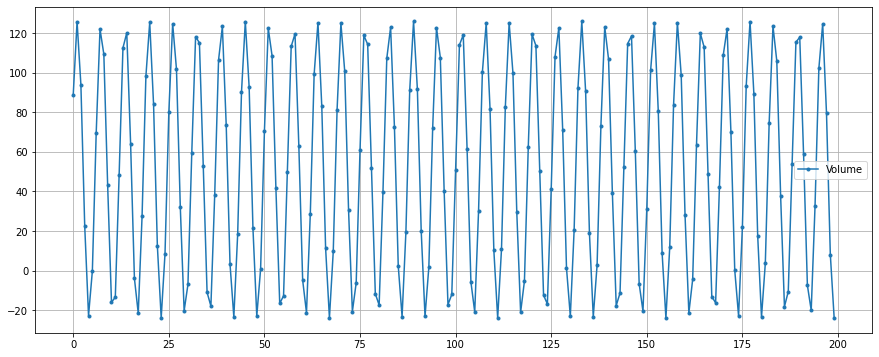

In [3]:
df = pd.DataFrame(np.sin(np.arange(-100,100))*np.random.randint(1,80)+np.random.randint(1,90))
df.columns= ['Volume']

plt.figure(figsize=(15,6))
plt.plot(df.Volume,marker='.',label='Volume')
plt.legend()
plt.grid()
plt.show()

In [4]:
class AR:
    
    def __init__(self,data=None,p=None):
        
        self.p = p
        self.data = data.copy()
        self.model  = None
        self.params = {}
    
    def fit(self):
        # Generate Lag variables upto max lags.
        for i in range(1,self.p+1):
            self.data['Lag_%d'%i] = self.data.Volume.shift(i)
        
        self.data = self.data.dropna().reset_index(drop=True)
       
        # We have all the necessary features to build a model now
        self.model = LinearRegression()
        
        # Input Varible(s) - Lag variables , Predictor Variable - Original Series
        self.model.fit(self.data.drop('Volume',axis=1),self.data.Volume)
        
        self.params['Intercept'] = self.model.intercept_
        
        for i,val in enumerate(list(self.model.coef_)):
            self.params['Lag_%d'%(i+1)] = val
        
        self.params = pd.Series(self.params).T
        
        ## Generate Residuals
        self.fittedvalues = self.data.drop('Volume',axis=1).dot(self.model.coef_.T) + self.model.intercept_               
        
        
        
    def predict(self,n_preds=20):
        
        X = self.data.copy()
        
        for i in range(n_preds):
            
            X = X.append(pd.Series(), ignore_index=True)
            
            for j in range(1,self.p+1):
                
                if j==1:
                    val  =  X.loc[len(X)-2,'Volume']
                else:
                    val =   X.loc[len(X)-2,'Lag_%d'%(j-1)]
                    
                X.loc[len(X)-1,'Lag_%d'%(j)] = val
                
                X.loc[len(X)-1,"Volume"] = X.iloc[len(X)-1,list(range(1,self.p+1))].dot(self.model.coef_.T) + self.model.intercept_               
                
          
        return X[len(self.data):].reset_index(drop=True)
        
        

In [5]:
class MA:
    
    def __init__(self,data=None,q=None):
        
        self.q = q
        self.data = data.copy()
        self.model  = None
        self.params = {}
    
    def fit(self):
        # Generate Lag variables upto max lags.
        for i in range(1,self.q+1):
            self.data['Lag_%d'%i] = self.data.Volume.shift(i)
        
        self.data = self.data.dropna().reset_index(drop=True)
       
        # We have all the necessary features to build a model now
        self.model = LinearRegression()
     
        # Input Varible(s) - Lag variables , Predictor Variable - Original Series
        self.model.fit(self.data.drop('Volume',axis=1),self.data.Volume)
        
        self.params['Intercept'] = self.model.intercept_
        
        for i,val in enumerate(list(self.model.coef_)):
            self.params['Lag_%d'%(i+1)] =  val
        
        self.params = pd.Series(self.params).T
        
        ## Generate Residuals
        self.fittedvalues = self.data.drop('Volume',axis=1).dot(self.model.coef_.T) + self.model.intercept_               
        
        
    def predict(self,n_preds=20):
        
        X = self.data.copy()
        
        for i in range(n_preds):
            
            X = X.append(pd.Series(), ignore_index=True)
            
            for j in range(1,self.q+1):
                
                if j==1:
                    val  =  X.loc[len(X)-2,'Volume']
                else:
                    val =   X.loc[len(X)-2,'Lag_%d'%(j-1)]
                    
                X.loc[len(X)-1,'Lag_%d'%(j)] = val
                
                X.loc[len(X)-1,"Volume"] = X.iloc[len(X)-1,list(range(1,self.q+1))].dot(self.model.coef_.T) + self.model.intercept_               
                
          
        return X[len(self.data):].reset_index(drop=True)
        
        

In [6]:
train_size = (int)(0.85 * df.shape[0])

train_df = df[:train_size].copy()
test_df = df[train_size:].reset_index(drop=True)

print(train_df.shape,test_df.shape)

(170, 1) (30, 1)


### CHOOSE P,Q

In [7]:
max_p = 2
max_q = 1

In [8]:
model1 = AR(data=train_df.copy(),p=max_p) # This is the model created by us.
model1.fit()

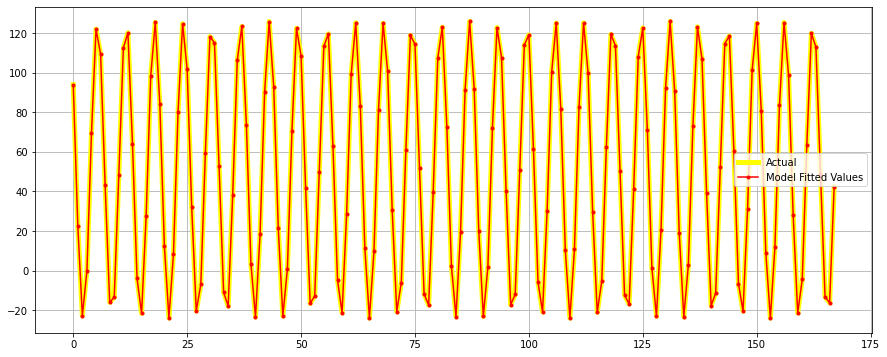

In [9]:
plt.figure(figsize=(15,6))
plt.plot(train_df.Volume.values[max_p:],marker='.',label='Actual',linewidth='5',color='yellow')
plt.plot(model1.fittedvalues.values,color='red',marker='.',label='Model Fitted Values')
plt.legend()
plt.grid()
plt.show()

In [10]:
resid = pd.DataFrame(train_df.Volume[max_p:].values - model1.fittedvalues.values)
resid.columns = ['Volume']
resid.head()

,Volume
0,1.421085e-14
1,0.000000e+00
2,7.105427e-15
3,1.421085e-14
4,1.421085e-14


In [11]:
mod = MA(q=max_q,data=resid.copy())
mod.fit()

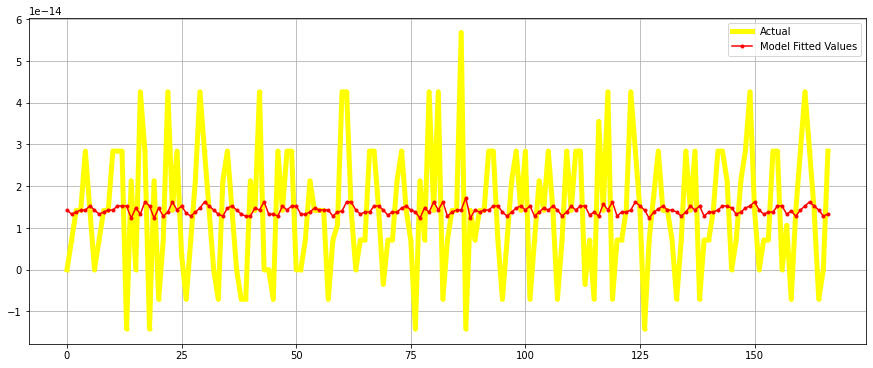

In [12]:
plt.figure(figsize=(15,6))
plt.plot(resid.Volume[max_q:].values,marker='.',label='Actual',linewidth='5',color='yellow')
plt.plot(mod.fittedvalues.values,color='red',marker='.',label='Model Fitted Values')
plt.legend()
plt.grid()
plt.show()

In [13]:
model1.params

Intercept    46.889165
Lag_1         1.080605
Lag_2        -1.000000
dtype: float64

In [14]:
mod.params

Intercept    1.332138e-14
Lag_1        6.857943e-02
dtype: float64

In [15]:
beta = model1.params.values[1:]
intercept1 = model1.params.values[0]

alpha = mod.params.values[1:]
intercept2 = mod.params.values[0]

print(beta,intercept1)
print(alpha,intercept2)

[ 1.08060461 -1.        ] 46.88916480144973
[0.06857943] 1.3321377391832065e-14


In [16]:
x1 = model1.predict(n_preds=len(test_df)).drop('Volume',axis=1)
x2 = mod.predict(n_preds=len(test_df)).drop('Volume',axis=1)
pred1 = x1@beta + x2@alpha + intercept1 + intercept2

## STATSMODELS MODEL

In [17]:
model_2 = ARIMA(train_df.copy(),order=(max_p,0,max_q))

In [18]:
model2= model_2.fit()

In [19]:
pred2 = model2.predict(start=len(train_df),end=len(train_df)+len(test_df)-1).reset_index(drop=True)

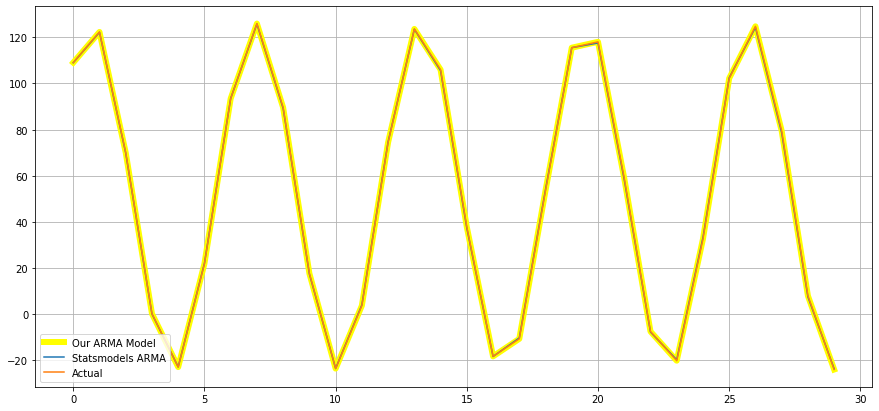

In [20]:
plt.figure(figsize=(15,7))
plt.plot(pred1,label='Our ARMA Model',color='yellow',linewidth='6')
plt.plot(pred2,label='Statsmodels ARMA')
plt.plot(test_df.Volume,label='Actual')
plt.legend()
plt.grid()
plt.show()

In [21]:
print("MAPE1: ",mean_absolute_percentage_error(test_df.Volume,pred1))
print("MAPE2: ",mean_absolute_percentage_error(test_df.Volume,pred2))

MAPE1:  0.0
MAPE2:  2.62
